In [1]:
%matplotlib inline

from pathlib import Path
from collections import Counter

import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Reshape, Dot, Embedding
from tensorflow.keras.preprocessing.sequence import skipgrams, make_sampling_table
from tensorflow.keras.callbacks import Callback, TensorBoard

import matplotlib.pyplot as plt
import seaborn as sns
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu_devices[0], True)

sns.set_style('white')
np.random.seed(42)

results_path = Path('results', 'financial_news')
analogy_path = Path('data', 'analogies-en.txt')
def format_time(t):
    m, s = divmod(t, 60)
    h, m = divmod(m, 60)
    return f'{h:02.0f}:{m:02.0f}:{s:02.0f}'

In [2]:
# word2vec - skipgram Architecture using Keras
SAMPLE_SIZE=.5              # portion of sentences to use for model
NGRAMS = 3                  # Longest ngram in text
MIN_FREQ = 10
SAMPLING_FACTOR = 1e-4
WINDOW_SIZE = 3
EMBEDDING_SIZE = 300
EPOCHS = 1
BATCH_SIZE = 2500

VALID_SET = 10      # Random set of words to get nearest neighbors for
VALID_WINDOW = 150  # Most frequent words to draw validation set from
NN = 10             # Number of nearest neighbors for evaluation

valid_examples = np.random.choice(VALID_WINDOW, size=VALID_SET, replace=False)
FILE_NAME = f'articles_{NGRAMS}_grams.txt'
file_path = results_path / FILE_NAME
tb_path = results_path / 'tensorboard'
if not tb_path.exists():
    tb_path.mkdir(parents=True, exist_ok=True)

In [3]:
# Build Data Set
sentences = file_path.read_text(encoding='UTF8').split('\n')
n = len(sentences)
max_length = 50
sentences = [s for s in sentences if len(s.split()) <= max_length]
print(f'Removed {n-len(sentences):,.0f} sentences containing more than {max_length} tokens')

Removed 59,554 sentences containing more than 50 tokens


In [4]:
words = ' '.join(np.random.choice(sentences, size=int(SAMPLE_SIZE*len(sentences)), replace=False)).split()
# Get (token, count) tuples for tokens meeting MIN_FREQ
token_counts = [t for t in Counter(words).most_common() if t[1] >= MIN_FREQ]
tokens, counts = list(zip(*token_counts))

# create id-token dicts & reverse dicts
id_to_token = pd.Series(tokens, index=range(1, len(tokens) + 1)).to_dict()
id_to_token.update({0: 'UNK'}) # set dummy value
token_to_id = {t: i for i, t in id_to_token.items()}
data = [token_to_id.get(word, 0) for word in words]
vocab_size = len(token_to_id)
vocab_size

60876

In [5]:
s = pd.Series(data).value_counts().reset_index()
s.columns = ['id', 'count']
s['token'] = s.id.map(id_to_token)
s.sort_values('count', ascending=False).head(10)

,id,count,token
0,0,411254,UNK
1,1,173082,company
2,2,171905,million
3,3,149588,said
4,4,119586,year
5,5,108890,quarter
6,6,83581,financial
7,7,75711,percent
8,8,75434,net
9,9,72558,new


In [6]:
s['count'].sum()

18006618

In [7]:
s.sort_values('id').token.dropna().to_csv(tb_path / 'meta.tsv', index=False)

In [8]:
# Analogies to ID
def get_analogies():
    df = pd.read_csv(analogy_path, header=None, squeeze=True, encoding='UTF8')
    categories = df[df.str.startswith(':')]
    analogies = df[~df.str.startswith(':')].str.split(expand=True)
    analogies.columns = list('abcd')
    return analogies
analogies = get_analogies()
analogies.head()

C:\Users\19498\AppData\Local\Temp\ipykernel_8748\191787428.py:3: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  df = pd.read_csv(analogy_path, header=None, squeeze=True, encoding='UTF8')


,a,b,c,d
1,athens,greece,baghdad,iraq
2,athens,greece,bangkok,thailand
3,athens,greece,beijing,china
4,athens,greece,berlin,germany
5,athens,greece,bern,switzerland


In [9]:
analogies.sample(10)

,a,b,c,d
5682,monrovia,liberia,caracas,venezuela
3501,funafuti,tuvalu,managua,nicaragua
24005,lion,lions,cow,cows
15776,clear,unclear,likely,unlikely
4870,ljubljana,slovenia,kathmandu,nepal
1706,beirut,lebanon,algiers,algeria
11774,henderson,nevada,modesto,california
17595,tall,taller,small,smaller
2855,copenhagen,denmark,luanda,angola
2544,caracas,venezuela,banjul,gambia


In [10]:
analogies_id = analogies.apply(lambda x: x.map(token_to_id))
analogies_id.notnull().all(1).sum()/len(analogies_id)

0.7232199117832389

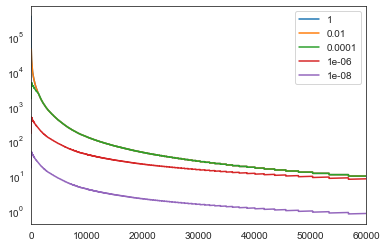

In [11]:
# Generate Sampling Probabilities
df = s['count'].to_frame('freq')
factors = [1, 1e-2, 1e-4, 1e-6, 1e-8]
for f in factors:
    sf = make_sampling_table(vocab_size, sampling_factor=f)
    df[f] = df.freq.mul(sf)

df.loc[:, factors].plot(logy=True, xlim=(0, 60000));

In [12]:
df = s['count'].to_frame('freq')
sf = make_sampling_table(vocab_size, sampling_factor=1e-2)
df[f] = df.freq.mul(sf)
df.sample(10).sort_values(by='freq', ascending=False)

,freq,1e-08
3256,740,740.0
6395,269,269.0
13125,90,90.0
19614,50,50.0
19843,49,49.0
25493,34,34.0
28770,29,29.0
40831,17,17.0
42759,16,16.0
43531,16,16.0


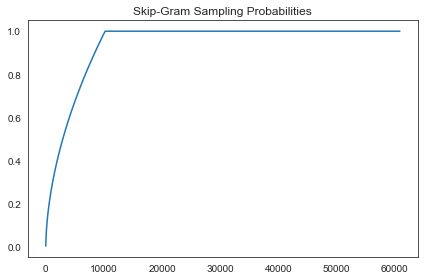

In [13]:
#  make_sampling_table: return array that is sorted by the highest probability of each word appearing
#  the return array of the function can be used to sampling_table of skipgram
sampling_table = make_sampling_table(vocab_size, sampling_factor=SAMPLING_FACTOR/10)
pd.Series(sampling_table).plot(title='Skip-Gram Sampling Probabilities')
plt.tight_layout();

In [14]:
sampling_table[10010:10018]

array([0.98985748, 0.98991197, 0.98996646, 0.99002095, 0.99007543,
       0.99012992, 0.9901844 , 0.99023887])

In [15]:
# Generate target-context word pairs
pairs, labels = skipgrams(sequence=data, vocabulary_size=vocab_size, window_size=WINDOW_SIZE,
                          sampling_table=sampling_table, negative_samples=1.0, shuffle=True)

print('{:,d} pairs created'.format(len(pairs)))

65,126,100 pairs created


In [16]:
target_word, context_word = np.array(pairs, dtype=np.int32).T
labels = np.array(labels, dtype=np.int8)
del pairs
target_word[:5]

array([15619,  6045, 15616,  2362,  5286])

In [17]:
df = pd.DataFrame({'target': target_word[:5], 'context': context_word[:5], 'label': labels[:5]})
df

,target,context,label
0,15619,33727,0
1,6045,22193,0
2,15616,11374,0
3,2362,56211,0
4,5286,17268,1


In [18]:
pd.Series(labels).value_counts()

0    32563050
1    32563050
dtype: int64

In [19]:
with pd.HDFStore(results_path / 'data.h5') as store:
    store.put('id_to_token', pd.Series(id_to_token))
    store.put('pairs', pd.DataFrame({'target' : target_word, 'context': context_word, 'labels': labels}))

with pd.HDFStore(results_path / 'data.h5') as store:
    id_to_token = store['id_to_token']
    pairs = store['pairs']

target_word, context_word, labels = pairs.target, pairs.context, pairs.labels

In [20]:
# Define Keras Model Components
# Word2vec MDL contains - 2 input layer, shared embedding layer, sigmoid output layer

# Scalar Input Variables
input_target = Input((1,), name='target_input')
input_context = Input((1,), name='context_input')

# Shared Embedding Layer
embedding = Embedding(input_dim=vocab_size, output_dim=EMBEDDING_SIZE, input_length=1, name='embedding_layer')
# 1st input layer
target = embedding(input_target)
target = Reshape((EMBEDDING_SIZE, 1), name='target_embedding')(target) # reshape inputs into the given shape
# 2nd input layer
context = embedding(input_context)
context = Reshape((EMBEDDING_SIZE, 1), name='context_embedding')(context)

# Create Similarity Measure(compute Dot project btw samples in two tensors)
dot_product = Dot(axes=1)([target, context])
dot_product = Reshape((1,), name='similarity')(dot_product)

# Sigmoid Output Layer
output = Dense(units=1, activation='sigmoid', name='output')(dot_product)

# Compile Training Model
model = Model(inputs=[input_target, input_context], outputs=output)
model.compile(loss='binary_crossentropy', optimizer='rmsprop')

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 target_input (InputLayer)      [(None, 1)]          0           []                               
                                                                                                  
 context_input (InputLayer)     [(None, 1)]          0           []                               
                                                                                                  
 embedding_layer (Embedding)    (None, 1, 300)       18262800    ['target_input[0][0]',           
                                                                  'context_input[0][0]']          
                                                                                                  
 target_embedding (Reshape)     (None, 300, 1)       0           ['embedding_layer[0][0]']    

In [21]:
# Validation Model
similarity = Dot(normalize=True, axes=1, name='cosine_similarity')([target, context])

# create a secondary validation model to run our similarity checks during training
validation_model = Model(inputs=[input_target, input_context], outputs=similarity)
validation_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 target_input (InputLayer)      [(None, 1)]          0           []                               
                                                                                                  
 context_input (InputLayer)     [(None, 1)]          0           []                               
                                                                                                  
 embedding_layer (Embedding)    (None, 1, 300)       18262800    ['target_input[0][0]',           
                                                                  'context_input[0][0]']          
                                                                                                  
 target_embedding (Reshape)     (None, 300, 1)       0           ['embedding_layer[0][0]']  

In [22]:
print(similarity)

KerasTensor(type_spec=TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None), name='cosine_similarity/MatMul:0', description="created by layer 'cosine_similarity'")


In [23]:
# Create Keras Callbacks

# Nearest Neighors & Analogies
test_set = analogies_id.dropna().astype(int)
a, b, c, actual = test_set.values.T
actual = actual.reshape(-1, 1)
n_analogies = len(actual)

class EvalCallback(Callback):

    def on_train_begin(self, logs={}):
        self.eval_nn()
        self.test_analogies()

    def on_train_end(self, logs={}):
        self.eval_nn()

    def on_epoch_end(self, batch, logs={}):
        self.test_analogies()

    @staticmethod
    def test_analogies():
        print('\nAnalogy Accuracy:\n\t', end='')
        embeddings = embedding.get_weights()[0]
        target = embeddings[c] + embeddings[b] - embeddings[a]
        neighbors = np.argsort(cdist(target, embeddings, metric='cosine'))
        match_id = np.argwhere(neighbors == actual)[:, 1]
        print('\n\t'.join(['Top {}: {:.2%}'.format(i, (match_id < i).sum() / n_analogies) for i in [1, 5, 10]]))

    def eval_nn(self):
        print('\n{} Nearest Neighbors:'.format(NN))
        for i in range(VALID_SET):
            valid_id = valid_examples[i]
            valid_word = id_to_token[valid_id]
            similarity = self._get_similiarity(valid_id).reshape(-1)
            nearest = (-similarity).argsort()[1:NN + 1]
            neighbors = [id_to_token[nearest[n]] for n in range(NN)]
            print('{}:\t{}'.format(valid_word, ', '.join(neighbors)))

    @staticmethod
    def _get_similiarity(valid_word_idx):
        target = np.full(shape=vocab_size, fill_value=valid_word_idx)
        context = np.arange(vocab_size)
        return validation_model.predict([target, context])


evaluation = EvalCallback()

In [24]:
# Tensorboard Callback
tensorboard = TensorBoard(log_dir=str(tb_path), write_graph=True, embeddings_freq=1,
                          embeddings_metadata={'embedding_layer': str(tb_path / 'meta.tsv')})

In [25]:
# Train Model
loss = model.fit(x=[target_word, context_word], y=labels, shuffle=True, batch_size=BATCH_SIZE, epochs=EPOCHS,
                 callbacks=[evaluation, tensorboard]) # uncomment if tensorboard bug is fixed
                 # callbacks=[evaluation])


10 Nearest Neighbors:
we:	chinchillas, caught, materialize_prove_correct, conceptual, vivendi, hacienda, darya_korsunskaya, grace, rm, interconnection
looking:	scenery, dodged, notoriety, polling, editing_sam_holmes, arrives_downing, confirmatory, failed_adequately, autoadapt, scythian_biosciences_corp
website:	cpcu, dispensers, kan, insys_therapeutics, their, ezcorp, topics, lula_da_silva, quetta, rohingya
assets:	forescout, cereals, rebuilding, take_or, avx, construction, jm, proliferation_treaty, nameplate_political_consultancy, roblin
april:	prosecutes_class, fixtures, contact_robert_willoughby, hsn, worked_tirelessly, toys, virtual_coin, eric_auchard, outage, gender_equality
adjusted:	insight_cnbc_contributors, blended, fries, digit, coyote, movement, vaca_muerta_shale, produces_sponsored, min, holds_bs
months:	known_hon_hai, merger, integer, syntel, lifetime_achievement_award, dismayed, spreadsheets, unprofitable, momenta, channeling
long:	holy, women_channel_honorees, eased_som

In [26]:
model.save(str(results_path / 'skipgram_model.h5'))

In [27]:
# Visualize Embeddings using Tensorboard
%load_ext tensorboard

In [28]:
%tensorboard --logdir results/financial_news/tensorboard/train

Launching TensorBoard...